<a href="https://colab.research.google.com/github/gravity0717/Capstone/blob/main/extract_features_%26_implement__Kmeans_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
1. multi CNN 의 pipelien 과 동일하게 가되 concat 계층에서 도출되는 tensor 값을 저장한다 .

2. 그 값을 clustering 한다 

```



In [1]:
import pandas as pd 
import json 
import tarfile 
import torch 
from torch.utils.data import Dataset
import math
from PIL import Image
from google.colab import drive 
drive.mount('/content/drive')
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Mounted at /content/drive


In [ ]:
from PIL import Image 
import glob
from torch.utils.data.dataset import Dataset
import numpy as np 
from torchvision import transforms
from sklearn.preprocessing import minmax_scale
import os 
class MU_normalized(Dataset):
  def __init__(self,csv_path):
    self.to_tensor=transforms.ToTensor()
    # Read the csv file 
    self.data_info = pd.read_csv(csv_path,header=None)
    # Read image path 
    self.img_path =  np.asarray(self.data_info.iloc[1:,9])
    self.label_arr =np.asarray(self.data_info.iloc[1:,8])
    self.label_arr=minmax_scale(self.label_arr)  
    # Read the log_view < log_view as label>

   
    self.transformations = transforms.Compose(
                                [transforms.ToTensor()
                                ,transforms.Resize((256,256)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])
    
  
        
  def __len__(self):
    return len(self.label_arr)
  # def wait to drop 

  def __getitem__(self,idx):
   #Get image name (actually path where images are )from pandas 
    if self.img_path is not np.nan:
      u=self.img_path[idx] + "/U.jpg" # 상의
      p=self.img_path[idx] + "/P.jpg" # 하의
      s=self.img_path[idx] + "/S.jpg" # 상의
    else: 
      pass 
    # Open Image 
    
    # 이미지가 경로에 없는 겨우 대비해야 할 것 
    if os.path.exists(u):
      u_as_img =Image.open(u).convert("RGB")
    else :
      u_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    if os.path.exists(p):
      p_as_img =Image.open(p).convert("RGB")
    else :
      p_as_img =Image.new("RGB", (256, 256), (255, 255, 255))

    if os.path.exists(s):
      s_as_img =Image.open(s).convert("RGB")
    else :
      s_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    #Transformations  
    u_as_tensor =self.transformations(u_as_img)
    p_as_tensor =self.transformations(p_as_img)
    s_as_tensor =self.transformations(s_as_img)
    
 
    
    return(u_as_tensor,p_as_tensor,s_as_tensor)



In [ ]:

from torchvision import models

model_pt=models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')


for p in model_pt.parameters():
  p.requires_grad=False # 가중치가 학습되지 않도록 함 
#in_features?



'''
pretrained model VGG 16 AlexNet LeNet .... Transfer learning 
'''
import torch.nn.functional as F
from torch import nn
class MultiCnn(nn.Module):
    def __init__(self):
        super(MultiCnn, self).__init__()
        self.VGG16 = model_pt.features


    def forward(self, top ,bot,shoes):
        top= self.VGG16(top)   #256*256
        bot = self.VGG16(bot)  
        shoes = self.VGG16(shoes) 
        N ,_,_ = top.size()

        top = top.reshape(N,-1)
        bot = bot.reshape(N,-1)
        shoes = shoes.reshape(N,-1)
        cat = torch.cat((top,bot,shoes),1)
        return cat
    


In [ ]:
from tqdm import tqdm 

li = []
def FeatureExtraction(model,data):
  model.eval()
  for idx, outfit in enumerate(tqdm(data)):
    u,p,s = outfit
    u=u.type(torch.cuda.FloatTensor)
    p=p.type(torch.cuda.FloatTensor)
    s=s.type(torch.cuda.FloatTensor)
    concatenated_feature = model(u,p,s)
    li.append(concatenated_feature)

  return li


In [ ]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

model=MultiCnn().to(device)
data = MU_normalized("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")
dataloader = DataLoader(data, batch_size=1, shuffle=False, drop_last=True) # suffle = False 로 해야 index 에 맞는 cluster 학습용 dataset 을 만들게 된다 

feature_list = []

feature_list = FeatureExtraction(model=model,data=data) 

100%|██████████| 4290/4290 [58:11<00:00,  1.23it/s]


In [ ]:
# feature list 저장하기
#import pickle
#with open("/content/drive/MyDrive/캡스톤/feature_list.pkl",'wb') as f:
#  pickle.dump(feature_list,f)

In [ ]:
# feature list 불러오기
import pickle
with open("/content/drive/MyDrive/캡스톤/feature_list.pkl",'rb') as f:
  x=pickle.load(f)

x



[tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2702, 0.1725, 0.0133,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2153, 0.3694, 0.0998,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        

In [ ]:
feature_list = x 

In [ ]:
f_l=[]
for x in feature_list: # tensor 값 numpy 로 바꾸고 flatten 진행 
  x=x.detach().cpu().numpy()
  x=x.reshape(-1)
  f_l.append(x)
f_l

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0.,

AttributeError: ignored

In [ ]:

data_DF = pd.DataFrame(f_l[:1000]) # 용량이 너무 커 RAM 이 튕겨서 1000개 만 insert 했음 #Randomly choose 하면 조금 더 성능이 좋아 질 것 같다

In [ ]:


data_DF.to_csv("/content/drive/MyDrive/캡스톤/feature_csv")

In [2]:
data = pd.read_csv("/content/drive/MyDrive/캡스톤/feature_csv")
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,98294,98295,98296,98297,98298,98299,98300,98301,98302,98303
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.drop(["Unnamed: 0"],axis =1,inplace=True)

In [6]:
data.to_csv("/content/drive/MyDrive/캡스톤/feature_csv")

In [7]:


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=, verbose =True)

kmeans.fit(data)






Initialization complete
Iteration 0, inertia 53417744.24936891
Iteration 1, inertia 28191397.17541542
Iteration 2, inertia 28075415.38296066
Iteration 3, inertia 28037871.71263787
Iteration 4, inertia 28013998.10381468
Iteration 5, inertia 27996665.020341866
Iteration 6, inertia 27959750.939140018
Iteration 7, inertia 27896919.51812759
Iteration 8, inertia 27847873.707407575
Iteration 9, inertia 27836453.35401285
Iteration 10, inertia 27833293.790673174
Iteration 11, inertia 27830898.329444997
Iteration 12, inertia 27830387.689471353
Iteration 13, inertia 27829522.542274456
Iteration 14, inertia 27829319.43730014
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 51378512.23436572
Iteration 1, inertia 28406451.396531686
Iteration 2, inertia 28175826.70060101
Iteration 3, inertia 28065029.612820692
Iteration 4, inertia 28002456.957531996
Iteration 5, inertia 27858992.634241495
Iteration 6, inertia 27681402.893621206
Iteration 7, inertia 27642815.

KMeans(n_clusters=3, verbose=True)

In [9]:
kmeans.cluster_centers_

array([[ 1.05854298e-02,  4.40685274e-03,  2.86374458e-03, ...,
         3.44355421e-03,  1.95799795e-03,  2.81080938e-04],
       [ 3.46944695e-18,  0.00000000e+00, -4.33680869e-18, ...,
         1.73472348e-18,  8.67361738e-19,  9.08659237e-03],
       [ 3.05035547e-03,  4.38689433e-03,  4.63864261e-03, ...,
         2.57341618e-03,  2.14714259e-03, -1.73472348e-18]])

In [8]:

import joblib

joblib.dump(
kmeans,"/content/drive/MyDrive/캡스톤/kmeans_cluster.pkl")

['/content/drive/MyDrive/캡스톤/kmeans_cluster.pkl']

In [18]:
from sklearn.decomposition import PCA 

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data)
data_center = pca.fit_transform(kmeans.cluster_centers_)


In [21]:
x=data_pca[:,0]
y=data_pca[:,1]

x_ = data_center[:,0]
y_ = data_center[:,1]

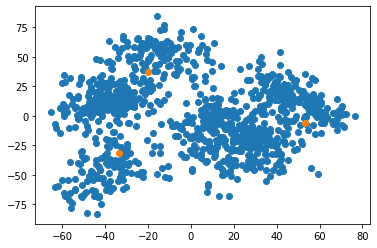

In [22]:
plt.scatter(x,y)
plt.scatter(x_,y_)